This does not have a reward for each individual turn. Just plays out d cycles of turns and uses the evaluation function at end.

In [1]:
from utils.game_map_class import GameMap
from utils.game_team_class import GameTeam
from utils.strategy_class import Strategy, RandomStrategy, RuleOfThumbStrategy
from utils.map_setup_functions import setGameBoardRandom, initializeFullRiskMap
from utils.heuristics import BST_Heuristic

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
import copy

In [4]:
def rollout_lookahead(team,riskMap,d,discount):
    '''Returns the best action according to lookahead with rollouts'''
    return greedy(team,riskMap,d,discount)[0]

In [21]:
def greedy(team,riskMap,d,discount):
    '''Greedily looks through all possible actions and determines the value of each from the current state
    using lookahead with rollouts. Returns action with maximum value and the value itself'''
    possible_attackers = team.getPossibleAttacks()
    print(possible_attackers)
    lookahead_list = []
    for attacker in possible_attackers:
        for defender in possible_attackers[attacker]:
            action = (attacker,defender)
            u = lookahead(discount,riskMap,action,d)
            lookahead_list.append((action,u))
    print(lookahead_list)
    if len(lookahead_list) == 0:
        return (None,None)
    return max(lookahead_list, key = lambda x: x[1])

In [6]:
def lookahead(discount,riskMap,action,d):
    ''' Computes successor states and probabilities of these successor states given the current riskMap
    
    Then for each of these successor states performs a rollout to get a value that that successor state and 
    multiplies it by the probability of that successor state. Takes the sum of those values and multiplies it
    by the discount factor to return the value of that function.
    '''
    
    # Gets basic information about current state of play
    attacking_territory, defending_territory = action
    num_attackers = riskMap.getTroops(attacking_territory)
    num_defenders = riskMap.getTroops(defending_territory)
    
    # Computes successor states and transition probabilities
    succ_state_probs = {}
    compute_succ_state_prob(1,num_attackers,num_defenders,succ_state_probs)
    
    sum_successors = 0
    for succ in succ_state_probs:
        
        # Sets up successor state
        sp = copy.deepcopy(riskMap)
        attacking_team = sp.getTeam(attacking_territory)
        defending_team = sp.getTeam(defending_territory)
        set_up_sp(sp,succ,attacking_team,defending_team,attacking_territory,defending_territory)
        
        # Gets value of successor state via rollout and multiplies by the transition probability to add to sum
        prob = succ_state_probs[succ]
        sum_successors += prob*rollout(discount,sp,d,attacking_team,defending_team)
        
    return discount*sum_successors

In [7]:
def compute_succ_state_prob(prob,num_attackers,num_defenders,succ_state_probs):
    """This recursive function run to completion is meant to take prob = 1 and a number of attackers
    and defenders for a battle and update the succ_state_probs dictionary with the possible outcomes mapped
    to their respective probabilities."""
    if num_attackers == 0 or num_attackers == 1 or num_defenders == 0:
        if (num_attackers,num_defenders) in succ_state_probs:
            succ_state_probs[(num_attackers,num_defenders)] += prob
        else:
            succ_state_probs[(num_attackers,num_defenders)] = prob
    if num_attackers == 2 and num_defenders == 1:
        compute_succ_state_prob(prob*5/12,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*7/12,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 3 and num_defenders == 1:
        compute_succ_state_prob(prob*125/216,num_attackers,num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*91/216,num_attackers - 1,num_defenders,succ_state_probs)
    if num_attackers > 3 and num_defenders == 1:
        compute_succ_state_prob(prob*95/144,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*49/144,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 2 and num_defenders > 1:
        compute_succ_state_prob(prob*55/216,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*161/216,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 3 and num_defenders > 1:
        compute_succ_state_prob(prob*295/1296,num_attackers, num_defenders - 2,succ_state_probs)
        compute_succ_state_prob(prob*35/108,num_attackers - 1, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*581/1296,num_attackers - 2, num_defenders,succ_state_probs)
    if num_attackers > 3 and num_defenders > 1:
        compute_succ_state_prob(prob*1445/3888,num_attackers, num_defenders - 2,succ_state_probs)
        compute_succ_state_prob(prob*2611/7776,num_attackers - 1, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*2275/7776,num_attackers - 2, num_defenders,succ_state_probs)

In [8]:
def set_up_sp(sp,succ,attacking_team,defending_team,attacking_territory,defending_territory):
    '''Sets up a successor state'''
    succ_num_attackers, succ_num_defenders = succ

    attacking_team.setTroops(attacking_territory, succ_num_attackers)
    defending_team.setTroops(defending_territory, succ_num_defenders)

    if succ_num_defenders == 0:

        # Declare the territory to the attacking team! 
        sp.setTeam(defending_territory, attacking_team)
        # Assign the territory to the attacking team
        attacking_team.addTerritory(defending_territory)
        defending_team.removeTerritory(defending_territory)

        # Move all but one remaining attacking troops to the territory
        attacking_team.moveTroops(attacking_territory, defending_territory, succ_num_attackers - 1)

In [19]:
def rollout(discount,sp,d,my_team,opponent):
    '''Rolls out using a stochastic policy (this is encoded in the strategy of my_team itself) against player. 
    Repeats rounds of turns to depth. If my_team wins, the reward is 100. If the opponent wins, the reward is 0.
    Otherwise, at the end of the rollout, we use the BST heuristic for both teams and the reward. We see what percentage
    of BTS between the two teams is attributed to the opponent (would be good for my_team) and use that as the reward'''
    ret = 0
    end_reached = False
    for t in range(d):
        if my_team.hasTeamWon():
            r = 100
            return (discount**t)*r
        opponent.playTurn()
        if opponent.hasTeamWon():
            r = 0
            return (discount**t)*r
        my_team.playTurn()
    if my_team.hasTeamWon():
        r = 100
        return (discount**(d-1))*r
    elif opponent.hasTeamWon():
        r = 0
        return (discount**(d-1))*r
    else:
        print(BST_Heuristic(my_team,sp))
        BST_my_team_sum = sum(list(BST_Heuristic(my_team,sp).values()))
        BST_opponent_sum = sum(list(BST_Heuristic(opponent,sp).values()))
        r = 100*BST_opponent_sum/(BST_my_team_sum+BST_opponent_sum)
        return (discount**(d-1))*r

In [10]:
full_risk_map = initializeFullRiskMap()
team_names = ["rollout_team","rollout_opponent"]
team_strategies = [RandomStrategy,RuleOfThumbStrategy]
risk_map, teams = setGameBoardRandom(team_names, full_risk_map, team_strategies)
teams[1].getPossibleAttacks()

{}

Adding 1 to Peru!
Adding 1 to Eastern United States!
Adding 1 to Western United States!
Adding 1 to Northern Europe!
Adding 1 to Quebec!
Adding 1 to Madagascar!
Adding 1 to Peru!
('Peru', ['Venezuela', 'Brazil'])
('Peru', 'Brazil')
Team rollout_team declares attack on Team rollout_opponent from Peru to Brazil
Attacking_dice:  [3, 1]
Defending_dice:  [4]
[False]
Attacking Troops Left:  2
Defending Troops Left:  1
Attacking_dice:  [2]
Defending_dice:  [6]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Eastern United States', ['Central America'])
('Eastern United States', 'Central America')
Team rollout_team declares attack on Team rollout_opponent from Eastern United States to Central America
Attacking_dice:  [1]
Defending_dice:  [1]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Northern Europe', ['Scandinavia'])
('Northern Europe', 'Scandinavia')
Team rollout_team declares attack on Team rollout_opponent from Northern Europe to Scandinavia
Attacking_dice: 

/Users/janieboettcher/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


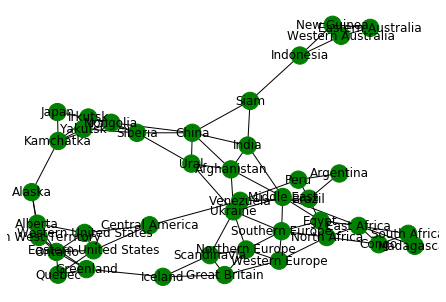

In [11]:
curr_team = teams[0]
defending_team = teams[1]
counter = 0
while len(teams[0].getPossibleAttacks())==0:
    curr_team.playTurn()
    curr_team_temp = curr_team
    curr_team = defending_team
    defending_team = curr_team_temp
    color_map = risk_map.getTeamColorMap()
    nx.draw(risk_map.graph, node_color = color_map, with_labels=True)
    plt.show()
    counter += 1

In [12]:
teams[0].getPossibleAttacks()

{'Madagascar': ['East Africa'],
 'Western United States': ['Alberta', 'Central America']}

In [26]:
rollout_lookahead(teams[0],risk_map,5,.95)

{'Madagascar': ['East Africa'], 'Western United States': ['Alberta', 'Central America']}
Adding 6 to Scandinavia!
('Scandinavia', 'Great Britain')
Team rollout_opponent declares attack on Team rollout_team from Scandinavia to Great Britain
Attacking_dice:  [4, 2, 1]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  7
Defending Troops Left:  0
('Great Britain', 'Western Europe')
Team rollout_opponent declares attack on Team rollout_team from Great Britain to Western Europe
Attacking_dice:  [6, 3, 2]
Defending_dice:  [6]
[False]
Attacking Troops Left:  5
Defending Troops Left:  1
Attacking_dice:  [4, 3, 2]
Defending_dice:  [6]
[False]
Attacking Troops Left:  4
Defending Troops Left:  1
Attacking_dice:  [4, 2, 1]
Defending_dice:  [6]
[False]
Attacking Troops Left:  3
Defending Troops Left:  1
Attacking_dice:  [6, 2]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Western Europe', 'North Africa')
Team rollout_opponent declares attack on Team rollout_te

Attacking_dice:  [3]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Iceland', ['Great Britain', 'Scandinavia'])
('Iceland', 'Scandinavia')
Team rollout_team declares attack on Team rollout_opponent from Iceland to Scandinavia
Attacking_dice:  [6, 4, 2]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  4
Defending Troops Left:  0
('Scandinavia', ['Great Britain'])
('Scandinavia', 'Great Britain')
Team rollout_team declares attack on Team rollout_opponent from Scandinavia to Great Britain
Attacking_dice:  [6, 4]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Alaska', ['Kamchatka'])
Adding 5 to India!
('India', 'Afghanistan')
Team rollout_opponent declares attack on Team rollout_team from India to Afghanistan
Attacking_dice:  [6, 3, 1]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  6
Defending Troops Left:  0
('Afghanistan', 'Middle East')
Team rollout_opponent declares attack on Team rollout_team from Afghan

{'Mongolia': 5.0, 'South Africa': 4.0, 'Madagascar': 1.0, 'Eastern United States': 5.0, 'Quebec': 2.0, 'Siam': 1.0, 'Great Britain': 4.0, 'Eastern Australia': 2.0, 'Iceland': 4.0, 'Ontario': 8.0, 'Greenland': 2.5, 'East Africa': 7.0, 'Egypt': 4.0, 'Congo': 3.0, 'Western United States': 4.0, 'Southern Europe': 6.0, 'Central America': 6.0}
Adding 6 to Scandinavia!
('Scandinavia', 'Ukraine')
Team rollout_opponent declares attack on Team rollout_team from Scandinavia to Ukraine
Attacking_dice:  [6, 3, 2]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  7
Defending Troops Left:  0
('Ukraine', 'Afghanistan')
Team rollout_opponent declares attack on Team rollout_team from Ukraine to Afghanistan
Attacking_dice:  [3, 2, 1]
Defending_dice:  [5]
[False]
Attacking Troops Left:  5
Defending Troops Left:  1
Attacking_dice:  [6, 4, 3]
Defending_dice:  [6]
[False]
Attacking Troops Left:  4
Defending Troops Left:  1
Attacking_dice:  [5, 3, 1]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  4
D

Defending Troops Left:  0
('Western Europe', 'Southern Europe')
Team rollout_opponent declares attack on Team rollout_team from Western Europe to Southern Europe
Attacking_dice:  [4, 3, 2]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  5
Defending Troops Left:  0
('Southern Europe', 'Egypt')
Team rollout_opponent declares attack on Team rollout_team from Southern Europe to Egypt
Attacking_dice:  [6, 5, 1]
Defending_dice:  [6, 1]
[False  True]
Attacking Troops Left:  3
Defending Troops Left:  2
Attacking_dice:  [6, 1]
Defending_dice:  [3, 1]
[ True False]
Attacking Troops Left:  2
Defending Troops Left:  1
Attacking_dice:  [4]
Defending_dice:  [6]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
Adding 1 to Mongolia!
Adding 1 to East Africa!
Adding 1 to Eastern Australia!
Adding 1 to Siam!
Adding 1 to Siam!
('Alberta', ['Alaska'])
('Alberta', 'Alaska')
Team rollout_team declares attack on Team rollout_opponent from Alberta to Alaska
Attacking_dice:  [3]
Defending_dice: 

('Madagascar', 'East Africa')

In [18]:
a = {1:2,2:3}
a.values()

dict_values([2, 3])